BERT, Classfication layer

In [1]:
name = "bert_oversampled"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv').dropna(subset=["data"])
test_data = pd.read_csv('../datasets/data_test.csv').dropna(subset=["data"])
valid_data = pd.read_csv('../datasets/data_valid.csv').dropna(subset=["data"])

train_data

all_labels = pd.concat([train_data["label"], test_data["label"], valid_data["label"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [3]:
# len(train_data) + len(test_data) + len(valid_data) = 38858
# df = train_data[train_data['data'].isna()]
# df

In [4]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.transform(labels)
    return texts, encoded_labels

In [5]:
from sklearn.utils import shuffle

df = train_data.copy()

print("Original Class Distribution:")
print(df['label'].value_counts())

# Specify minority classes directly
minority_labels = ['cruciate-ligament-minor', 'cruciate-ligament-urgent', 'meniscus-minor']

# Calculate the number of samples needed to match the most populous class
class_counts = df['label'].value_counts()
majority_class_count = class_counts.max()

# Initialize an empty dataframe to collect oversampled data
oversampled_dfs = [df]

for label in minority_labels:
    minority_df = df[df['label'] == label]
    required_samples = majority_class_count - class_counts[label]
    replication_factor = required_samples // len(minority_df)  # Calculate replication factor
    oversampled_minority_df = pd.concat([minority_df] * replication_factor, ignore_index=True)
    oversampled_dfs.append(oversampled_minority_df)

# Combine the original dataframe with the oversampled minority dataframes
balanced_df = pd.concat(oversampled_dfs, ignore_index=True)

# Shuffle the dataset
balanced_df = shuffle(balanced_df, random_state=42)
train_data = balanced_df.copy()

print("New Class Distribution After Shuffling:")
print(balanced_df['label'].value_counts())

Original Class Distribution:
label
other-minor                 9698
meniscus-urgent             9226
cruciate-ligament-urgent    2382
meniscus-minor              1663
cruciate-ligament-minor      355
Name: count, dtype: int64
New Class Distribution After Shuffling:
label
other-minor                 9698
cruciate-ligament-minor     9585
cruciate-ligament-urgent    9528
meniscus-urgent             9226
meniscus-minor              8315
Name: count, dtype: int64


In [6]:
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [7]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-german-cased')

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [8]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-08-06 01:16:36.570067: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-06 01:16:36.570087: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-06 01:16:36.570092: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-06 01:16:36.570105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-06 01:16:36.570115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained('google-bert/bert-base-german-cased', num_labels=len(label_encoder.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[ "accuracy" ]
)


In [11]:
# Train the model with early stopping callback
history = model.fit(train_dataset.shuffle(1000).batch(64),
          validation_data=valid_dataset.batch(64),
          epochs=3)


Epoch 1/3


2024-08-06 01:17:14.174004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


725/725 [==============================] - 4840s 7s/step - loss: 1.0525 - accuracy: 0.5439 - val_loss: 1.2833 - val_accuracy: 0.4562
Epoch 2/3
725/725 [==============================] - 4923s 7s/step - loss: 0.6269 - accuracy: 0.7323 - val_loss: 1.1170 - val_accuracy: 0.5424
Epoch 3/3
725/725 [==============================] - 4812s 7s/step - loss: 0.4424 - accuracy: 0.8083 - val_loss: 1.1238 - val_accuracy: 0.5719


In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Metrics to plot
metrics_names = ["accuracy",'loss']

plt.figure(figsize=(10, 7))

for i, metric in enumerate(metrics_names, 1):
    plt.subplot(2, 3, i)
    plt.plot(epochs, history_dict[metric], 'bo', label=f'Training {metric}')
    plt.plot(epochs, history_dict[f'val_{metric}'], 'b', label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

243/243 [==============================] - 180s 737ms/step - loss: 1.0703 - accuracy: 0.5839
Loss: 1.0703177452087402
Accuracy: 0.5838805437088013


In [13]:
model.save_pretrained(name)
tokenizer.save_pretrained(name + "_tokenizer")

('bert_oversampled_tokenizer/tokenizer_config.json',
 'bert_oversampled_tokenizer/special_tokens_map.json',
 'bert_oversampled_tokenizer/vocab.txt',
 'bert_oversampled_tokenizer/added_tokens.json')

In [14]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

243/243 [==============================] - 168s 683ms/step


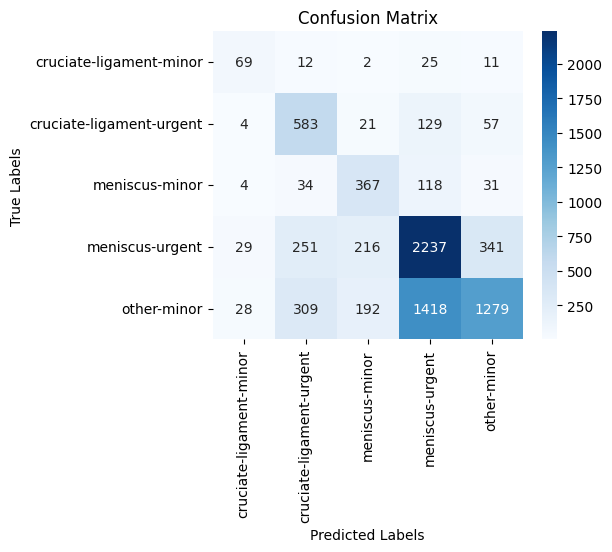

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.51      0.58      0.55       119
cruciate-ligament-urgent       0.49      0.73      0.59       794
          meniscus-minor       0.46      0.66      0.54       554
         meniscus-urgent       0.57      0.73      0.64      3074
             other-minor       0.74      0.40      0.52      3226

                accuracy                           0.58      7767
               macro avg       0.56      0.62      0.57      7767
            weighted avg       0.63      0.58      0.57      7767



In [17]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_, output_dict=True)

In [18]:
df = pd.DataFrame(report).transpose()
df.to_csv(name + "_report.csv")